# BAKGRUND

#### BEHOV
* Redaktionen vill förstå när och hur läsare är som mest engagerade och aktiva digitalt.
* Det driver bland annat deras publiceringsmönster och konverteringsstrategi.
* Vill gärna få det nedbrutet på sektionsnivå så att det kan driva avdelningarnas individuella redaktionella strategi. 
* Dels vill man se absoluta tal, dels relativt en föregående period för att se om läsbeteenden har förändrats.

#### PROBLEM
* Vi tittar periodiskt på detta - ungefär två gånger om året. 
* Kräver ofta stor handpåläggning att hämta, bearbeta och visualisera datat - väldigt manuellt arbete.
* Metoden kan variera - ex. hur vi sållar ut outliers, justerar för inflation/deflation i jämförelsen mellan perioder.

#### LÖSNING 
* Gör en semi-automatisk notebook som spottar ut graferna vi vill ha genom en konsekvent metod. 
* Detta minskar det manuella arbetet och ökar flexibiliteten att möta mer spontana behov. 
* Det gör också att vi kan förbättra metoden över tid. 
* Förhoppningsvis kan detta dessutom användas av flera varumärken - och fler ögon kommer göra koden väsentligt bättre.
* Väldigt lättanpassat för data som finns i Reynolds.

#### OBS!
* Det finns säkerligen förbättringspotential i detta - all feedback uppskattas!
* Finns på Github under reading-heatmaps

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import normalize
from datetime import datetime
import matplotlib.ticker as mtick

# Special functions for this purpose
from functions import date_check, transform_weekday, normalise_weeks, detect_outlier, remove_outliers, standard_pivot, comparison_pivot, pivot_method, filter_params, heatmap

# 1. SET-UP

#### What you need to decide prior to running the notebook:
* The date range you want to examine. 
* An older date range if you want to make a comparison.
* If you want to examine browsers or accounts.

In [2]:
# SELECT THE APPROPRIATE DATA WAREHOUSE
PROJECT = 'data-warehouse-dn'

# SELECT A TIME PERIOD TO ANALYSE. (MAKE SURE IT IS MADE UP OF FULL WEEKS - USE THE FUNCTION BELOW). 
FROM_DATE = '2021-02-01'
TO_DATE = '2021-04-25'

# SELECT A COMPARISON TIME PERIOD (PREFERABLY WITH COMPARABLE # OF WEEKS - ALTHOUGH WE WILL NORMALISE BY WEEK LATER).
FROM_DATE_COMP = '2020-08-04'
TO_DATE_COMP = '2020-10-26'

# SELECT UNIT OF ANALYSIS: EITHER BROWSERS OR ACCOUNTS.
ID = 'client_id' # user_id, client_id

# (We will use this later.)
dates = {
    'from_date': FROM_DATE,
    'to_date': TO_DATE,
    'from_date_comp': FROM_DATE_COMP,
    'to_date_comp': TO_DATE_COMP
}

#### Make sure there is an equal number of "day types" (e.g. Monday, Tuesday) in each date range - i.e. that you have selected "complete weeks." The code block below will check this for you.

In [3]:
print("CURRENT DATE RANGE")
date_check(from_date=FROM_DATE, to_date=TO_DATE) 
    
print("\nCOMPARISON DATE RANGE")
date_check(from_date=FROM_DATE_COMP, to_date=TO_DATE_COMP)

CURRENT DATE RANGE
Approved date range. Equal number of days of week.
Number of days: 84
Number of weeks: 12

COMPARISON DATE RANGE
Approved date range. Equal number of days of week.
Number of days: 84
Number of weeks: 12


# 2. IMPORT DATA

## 2.1 READING (PAGEVIEWS, MINUTES SPENT, USERS)

In [4]:
# SELECT GROUPING VARIABLE
GROUPING = 'device_category' # Total, section, device_category, login_status, referrer_category, data_source


In [5]:
# This is the string to query in order to get reading data. 
# Note that it is a function that is inputed at a later stage. So you only need to manipulate it once here to get impact across queries. 

# OBSERVE: If you wish to add special filters, you have to do it directly in this query.

def reading_query_text(from_date, to_date, grouping=GROUPING):
    
    if grouping == 'Total':
        GROUPING_QUERY_INPUT = '"Total" AS Total'
    else:
        GROUPING_QUERY_INPUT = GROUPING

    query = (f'''
                
                ########################################################################################################
                ############# GET ACTIVE TIME PER PAGEVIEW
                ########################################################################################################
                WITH active_duration AS (
                  SELECT
                    pageview_id,
                    SUM(SAFE_CAST(label AS INT64)) AS sum_time
                  FROM `data-warehouse-dn.reynolds.event` 
                  WHERE 1=1
                    AND action = 'Active Duration'
                    AND date BETWEEN "{from_date}" AND "{to_date}"
                  GROUP BY 1
                )
                
                ########################################################################################################
                ############# MAIN QUERY
                ########################################################################################################
                
                SELECT 
                    
                  ##########################################
                  ### Groupings
                  ##########################################
                  pv.date,
                  EXTRACT(DAYOFWEEK FROM pv.date) AS weekday,
                  EXTRACT(HOUR FROM pv.timestamp AT TIME ZONE "Europe/Stockholm") AS hour, 
                  {GROUPING_QUERY_INPUT},

                  ##########################################
                  ### KPI:s
                  ##########################################
                  COUNT(DISTINCT pv.pageview_id) AS n_pageviews,
                  COUNT(DISTINCT
                    CASE WHEN LOWER(page_type) IN ("start page", "article list page") 
                    THEN pv.pageview_id ELSE NULL END) AS n_flak_pageviews, 
                  COUNT(DISTINCT
                    CASE WHEN LOWER(page_type) IN ("articlepage", "article page") 
                    THEN pv.pageview_id ELSE NULL END) AS n_article_pageviews, 
                  COUNT(DISTINCT
                    CASE WHEN ev.action = "Active Duration" AND LOWER(page_type) IN ("articlepage", "article page") AND SAFE_CAST(ev.label AS INT64) > 10000 # At least 10 seconds
                    THEN pv.pageview_id ELSE NULL END) AS n_real_article_pageviews,
                  COUNT(DISTINCT
                    CASE WHEN LOWER(page_type) IN ("articlepage", "article page") AND sum_time > 180000 # At least 3 minutes
                    THEN pv.pageview_id ELSE NULL END) AS n_longreads,
                  ROUND(SUM(DISTINCT
                    CASE WHEN ev.action = "Active Duration" 
                    THEN SAFE_CAST(ev.label AS INT64) ELSE NULL END
                    ) / 1000 / 60, 1) AS n_active_minutes,
                  ROUND(SUM(DISTINCT
                    CASE WHEN ev.action = "Active Duration" AND LOWER(page_type) IN ("articlepage", "article page") 
                    THEN SAFE_CAST(ev.label AS INT64) ELSE NULL END
                    ) / 1000 / 60, 1) AS n_active_article_minutes,
                  COUNT(DISTINCT pv.user_id) AS n_accounts,
                  COUNT(DISTINCT pv.client_id) AS n_browsers

                FROM `{PROJECT}.reynolds.pageview` pv 
                LEFT JOIN `{PROJECT}.reynolds.event` ev ON ev.date = pv.date AND ev.pageview_id = pv.pageview_id
                LEFT JOIN active_duration ad ON pv.pageview_id = ad.pageview_id

                WHERE 1=1
                
                  ##########################################
                  ### Essential filters
                  ########################################## 
                  AND pv.date BETWEEN "{from_date}" AND "{to_date}"
                  
                  ##########################################
                  ### Analysis filters (have to be manually disabled/enabled)
                  ##########################################
                  #AND section IN '("Kultur")' # e.g. '("Kultur")' OR ("Nyheter", "Världen", "Sverige", "Ekonomi", "Kultur", "Sport", "STHLM", "Gbg", "Ledare", "DN Debatt", "Insidan") -------------------- DISABLE / ENABLE
                  #AND login_status IN ("Logged Out") ------------------------------------------------------------------------------------------------------------------------------------------------------ DISABLE / ENABLE
                  
                  ##########################################
                  ### Non-essential filters
                  ##########################################
                  #AND {ID} NOT IN ("", "N/A", "(not set)")
                  #AND {ID} IS NOT NULL
                  #AND content_id NOT LIKE "%dn.adhoc.%"
                  #AND content_id NOT LIKE "%dn.ctf%"
                
                GROUP BY 1,2,3,4

            '''
            )
    
    return(query)

In [6]:
df_reading_raw = pd.read_gbq(reading_query_text(from_date=FROM_DATE, to_date=TO_DATE, grouping=GROUPING), project_id=PROJECT)
df_reading_comp_raw = pd.read_gbq(reading_query_text(from_date=FROM_DATE_COMP, to_date=TO_DATE_COMP, grouping=GROUPING), project_id=PROJECT)

# Fix weekdays from numbers to words.
transform_weekday(data=df_reading_raw)
transform_weekday(data=df_reading_comp_raw)

Downloading: 100%|██████████| 6851/6851 [00:01<00:00, 6407.39rows/s]


In [7]:
df_reading = df_reading_raw.copy()
df_reading_comp = df_reading_comp_raw.copy()

# Outliers are removed by looking at pageviews by weekday, hour and the chosen grouping parameter - removing all that are beyond three standard deviation from the mean. 
# Given a roughly normal distribution, about 0-2% of the data should be shaved off. 
df_reading = remove_outliers(data=df_reading, partition=GROUPING)
df_reading_comp = remove_outliers(data=df_reading_comp, partition=GROUPING)

99.0% of original data remains.
100.0% of original data remains.


In [8]:
# Aggregate the KPIs based on mean aggregation - since we want the average of each KPI per WEEK
kpis = {'n_pageviews':'mean',
        'n_flak_pageviews':'mean',
        'n_article_pageviews':'mean',
        'n_real_article_pageviews':'mean',
        'n_longreads':'mean',
        'n_active_minutes':'mean',
        'n_active_article_minutes':'mean',
        'n_browsers':'mean',
        'n_accounts':'mean'}

# Eliminate dates from data - group on weekday and hour (+ extra grouping)
df_reading = df_reading.groupby(['weekday', 'hour', f'{GROUPING}']).aggregate(kpis).reset_index()
df_reading_comp = df_reading_comp.groupby(['weekday', 'hour', f'{GROUPING}']).aggregate(kpis).reset_index()

In [9]:
# Add some more KPIs
def add_metrics(data):
    
    data = (
        data
        .assign(share_flak_pageviews=lambda x: x['n_flak_pageviews'] / x['n_pageviews'] * 100)
        .assign(share_longreads=lambda x: x['n_longreads'] / x['n_article_pageviews'] * 100)
        .assign(share_real_longreads=lambda x: x['n_longreads'] / x['n_real_article_pageviews'] * 100)
        .assign(n_seconds_per_pageview=lambda x: x['n_active_minutes'] / x['n_pageviews'] * 60)
        .assign(n_seconds_per_article_pageview=lambda x: x['n_active_minutes'] / x['n_article_pageviews'] * 60)
    )
    
    return(data)

In [10]:
df_reading = add_metrics(df_reading)
df_reading_comp = add_metrics(df_reading_comp)

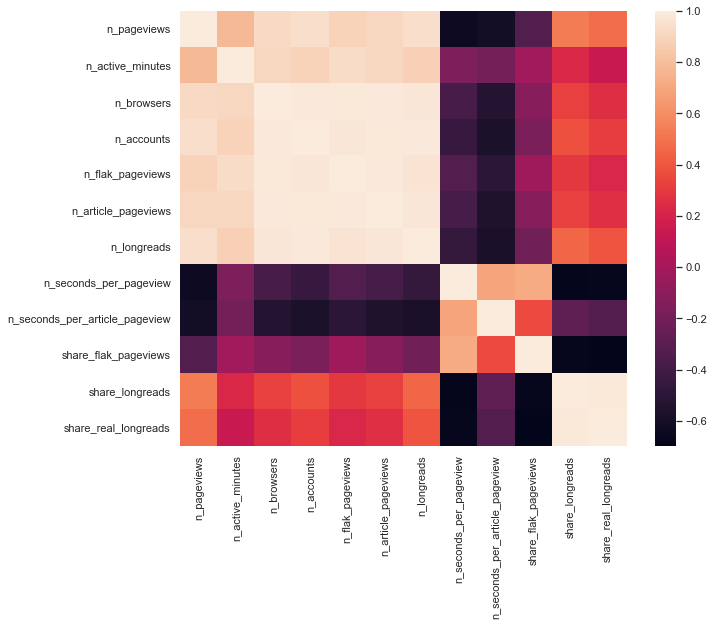

In [11]:
# Here we can see which KPIs correlate with each other - which helps us create insightful heatmaps

sns.set(rc={'figure.figsize':(10,8)})

sns.heatmap(df_reading[[
    'n_pageviews', 'n_active_minutes', 'n_browsers', 'n_accounts', 'n_flak_pageviews', 
    'n_article_pageviews', 'n_longreads', 'n_seconds_per_pageview', 'n_seconds_per_article_pageview',
    'share_flak_pageviews', 'share_longreads', 'share_real_longreads'
]].corr(method='spearman')); # spearman = rankkorrelation = nice på skev data

#plt.savefig(f'kpi_correlation_table.png', bbox_inches = "tight")

## 2.2 ARTICLE PUBLICATIONS AND PURCHASES

#### We do not filter for outliers here, in the same way that is done for consumer metrics. This is because publishing and purchasing is less variable.

In [12]:
# This is the string to query in order to get posting data. 
# Note that it is a function that is inputed at a later stage. So you only need to manipulate it once here to get impact across queries. 

def posting_query_text(from_date, to_date):

    query = f'''
    
                SELECT 
                
                  ##########################################
                  ### Groupings
                  ##########################################
                  s.name AS section,
                  EXTRACT(DAYOFWEEK FROM publication_time AT TIME ZONE "Europe/Stockholm") AS weekday, 
                  EXTRACT(HOUR FROM publication_time AT TIME ZONE "Europe/Stockholm") AS hour,
                  
                  ##########################################
                  ### KPI:s
                  ##########################################
                  COUNT(DISTINCT art.identifier.id) AS n_publications,
                  #COUNT(DISTINCT pur.id) AS n_purchases 
                  
                FROM `data-warehouse-dn.content.article` art,
                UNNEST(sections) s
                #LEFT JOIN `bn-analytics.orders.order_latest_norm` pur
                  #ON pur.article_id = art.identifier.id
                
                WHERE 1=1
                
                  ##########################################
                  ### Essential filters 
                  ##########################################
                  AND art.publication_time BETWEEN "{from_date}" AND "{to_date}"
                  
                  ##########################################
                  ### Analysis filters (have to be manually disabled/enabled)
                  ##########################################
                  #AND section IN '("Kultur")' # e.g. '("Kultur")' OR ("Nyheter", "Världen", "Sverige", "Ekonomi", "Kultur", "Sport", "STHLM", "Gbg", "Ledare", "DN Debatt", "Insidan") -------------------- DISABLE / ENABLE
                  
                GROUP BY 1,2,3

            '''
    
    return(query)

In [13]:
df_posting = pd.read_gbq(posting_query_text(from_date=FROM_DATE, to_date=TO_DATE), project_id=PROJECT)

df_posting_comp = pd.read_gbq(posting_query_text(from_date=FROM_DATE_COMP, to_date=TO_DATE_COMP), project_id=PROJECT)

# Fix weekdays from numbers to words.
transform_weekday(data=df_posting)
transform_weekday(data=df_posting_comp)

# Normalise values based on # of weeks.
df_posting[['n_publications']] = normalise_weeks(from_date=FROM_DATE, to_date=TO_DATE, data=df_posting[['n_publications']])
df_posting_comp[['n_publications']] = normalise_weeks(from_date=FROM_DATE, to_date=TO_DATE, data=df_posting_comp[['n_publications']])

Downloading: 100%|██████████| 1185/1185 [00:00<00:00, 5272.90rows/s]


# 3. VISUALISE: HEATMAPS

#### The heatmaps function has a input variable "comp_data" referring to a comparable dataset. If you add a dataset to this variable, you can compare changes over time.

## 3.1 READING (PAGEVIEWS, MINUTES SPENT, USERS)

In [14]:
# Use this to see if there are variable levels that you wish to remove before visualisation. 
(
    df_reading
    .groupby(f'{GROUPING}')
    .aggregate({'n_pageviews':'sum'})
    .sort_values('n_pageviews', ascending=False)
    .round()
    .reset_index()
)

,device_category,n_pageviews
0,mobile,23523427.0
1,tablet,16212449.0
2,desktop,7568812.0
3,other,496.0


In [15]:
# Use to clean data if necessary. 
df_reading = (
    df_reading
    #.query('login_status in ("Logged In", "Logged Out")')
    .query('device_category != "other"')
    #.query('section in ("Världen", "Sverige", "Ekonomi", "Kultur", "Sport", "STHLM", "Gbg", "Ledare", "DN Debatt", "Insidan")')
)

df_reading_comp = (
    df_reading_comp
    #.query('login_status in ("Logged In", "Logged Out")')
    .query('device_category != "other"')
    #.query('section in ("Världen", "Sverige", "Ekonomi", "Kultur", "Sport", "STHLM", "Gbg", "Ledare", "DN Debatt", "Insidan")')
)

In [16]:
df_reading_comp.aggregate({'n_pageviews':'sum'}).round()

n_pageviews    48899914.0
dtype: float64

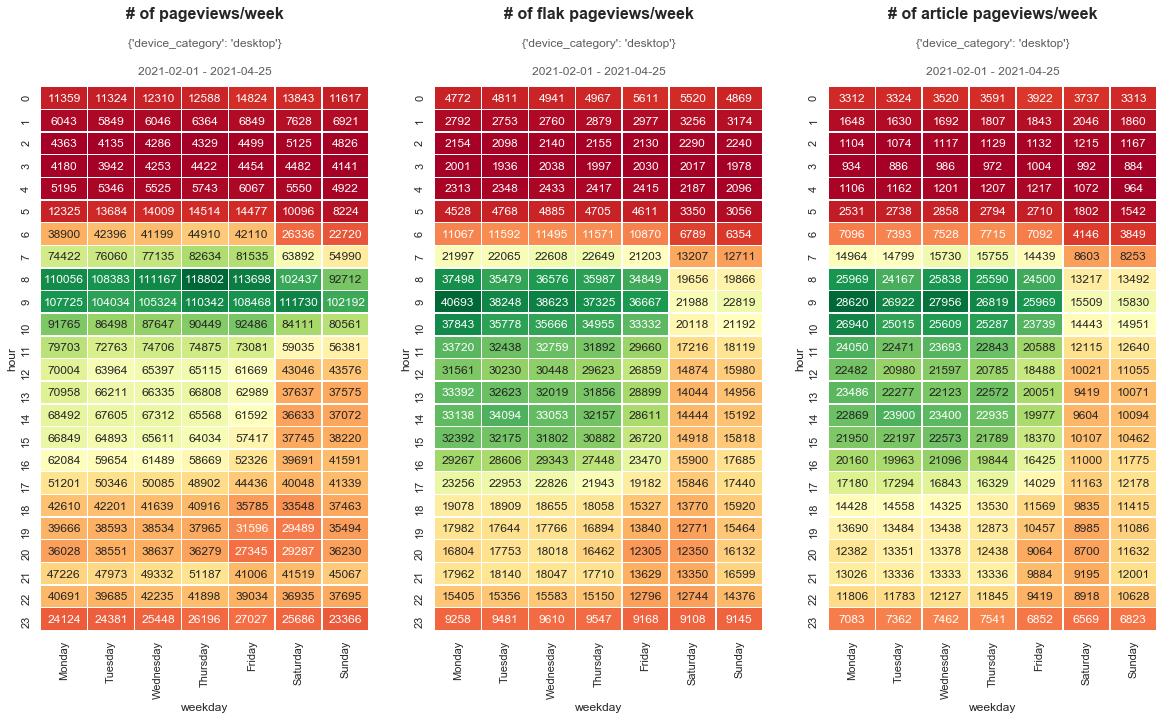

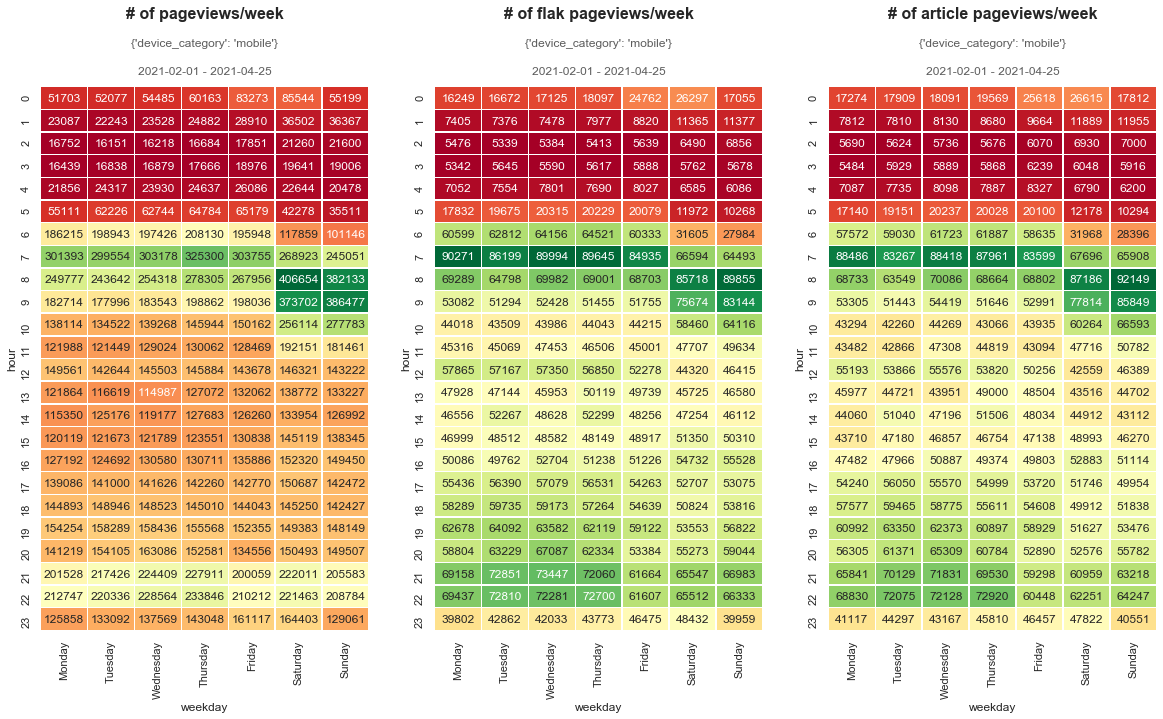

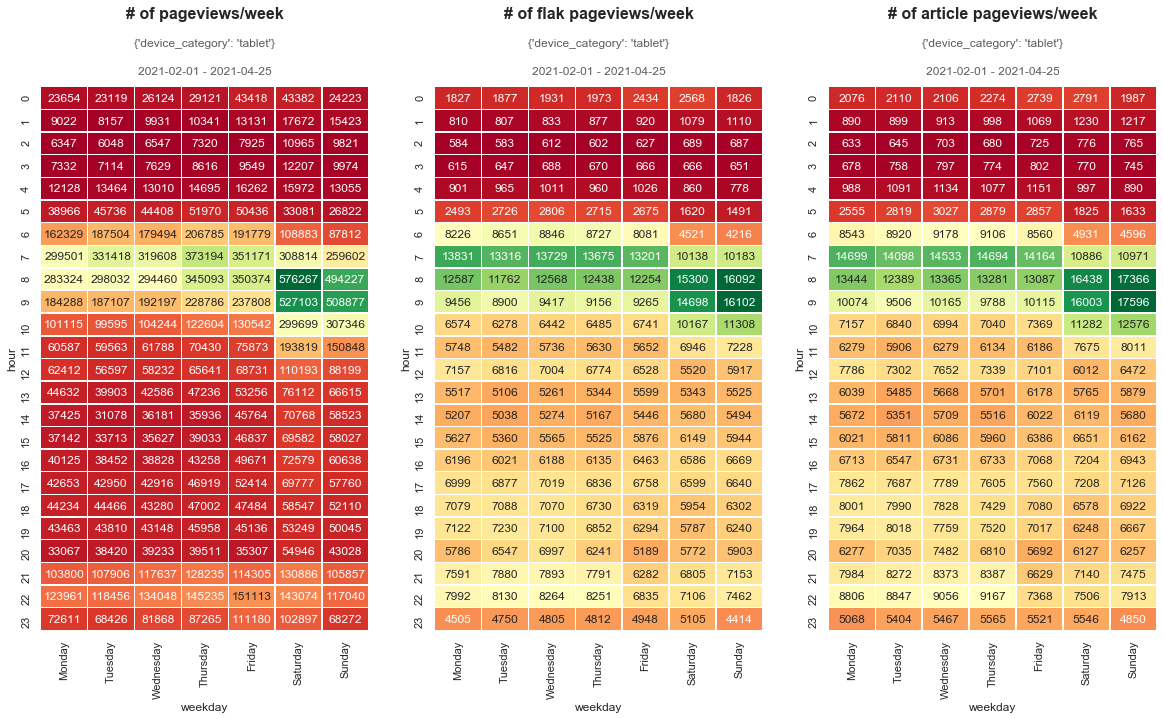

In [17]:
# Maximum three metrics!
metrics = {
    'n_pageviews': '# of pageviews/week',
    'n_flak_pageviews': '# of flak pageviews/week', 
    'n_article_pageviews': '# of article pageviews/week', 
}

# Select which sections to examine.
grouping_list = df_reading[f'{GROUPING}'].unique()

for val in grouping_list:
    
    # Select filtering parameters
    params = {
        f'{GROUPING}': f'{val}',
        
        # YOU CAN INCLUDE OTHER "FAKE" PARAMETERS. IT WON'T FILTER ON THIS BUT WILL WRITE IT OUT IN THE GRAPH. 
        #'login_status': 'Logged Out'
        #'section': 'Kultur' 
    }

    # Visualise behavioural heatmaps
    heatmap(params=params, 
            data=df_reading, 
            metrics=metrics,
            dates=dates); # add comp_data=df_reading_comp 
    
    #plt.savefig(f'{FROM_DATE}_pageviews_{TO_DATE}_{params}.png')
    #plt.savefig(f'{FROM_DATE}_pageviewscomp_{TO_DATE}_{params}.png')

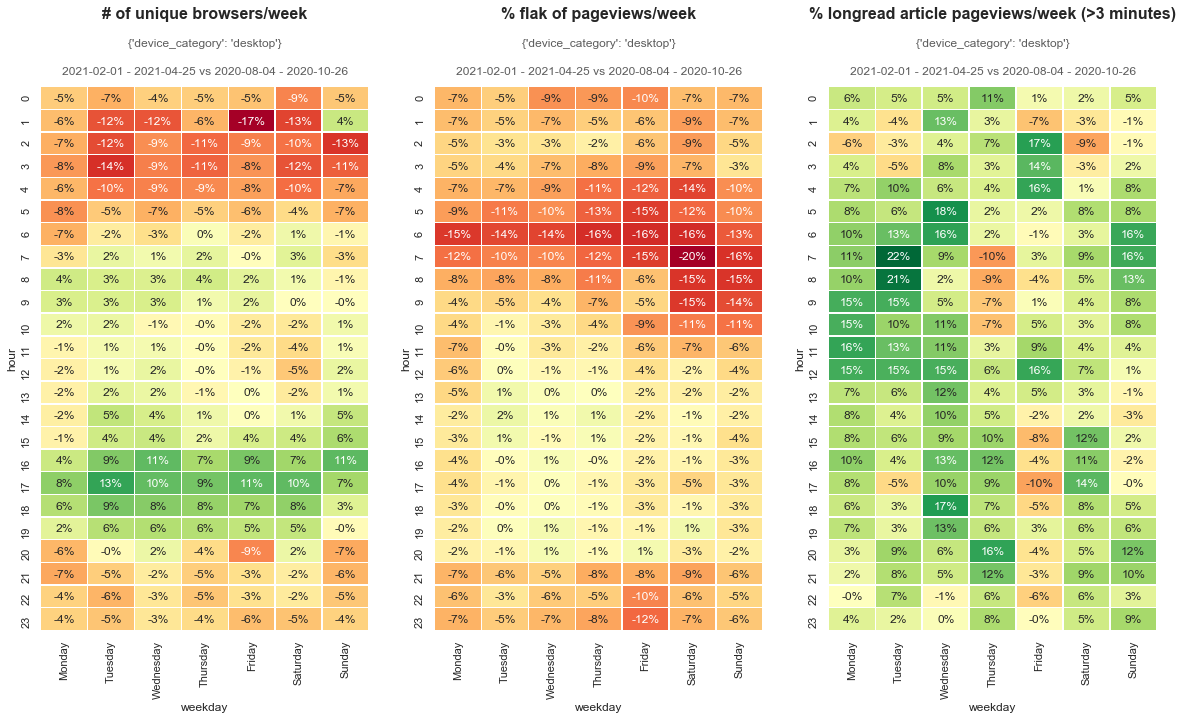

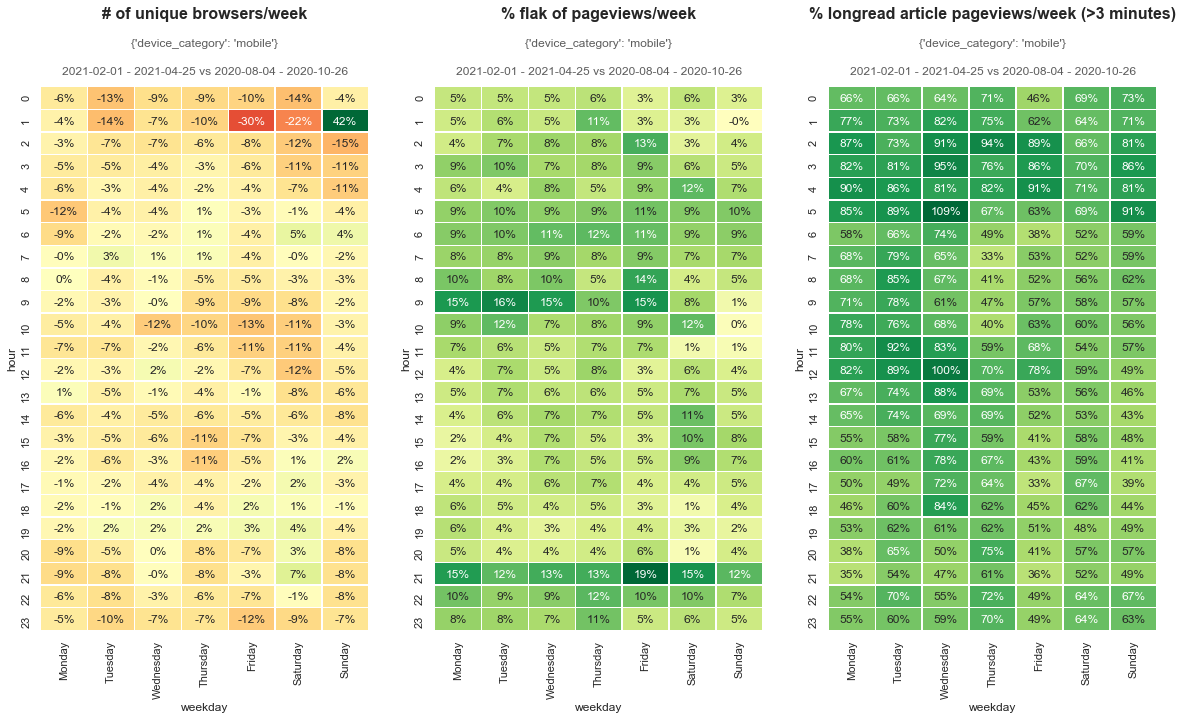

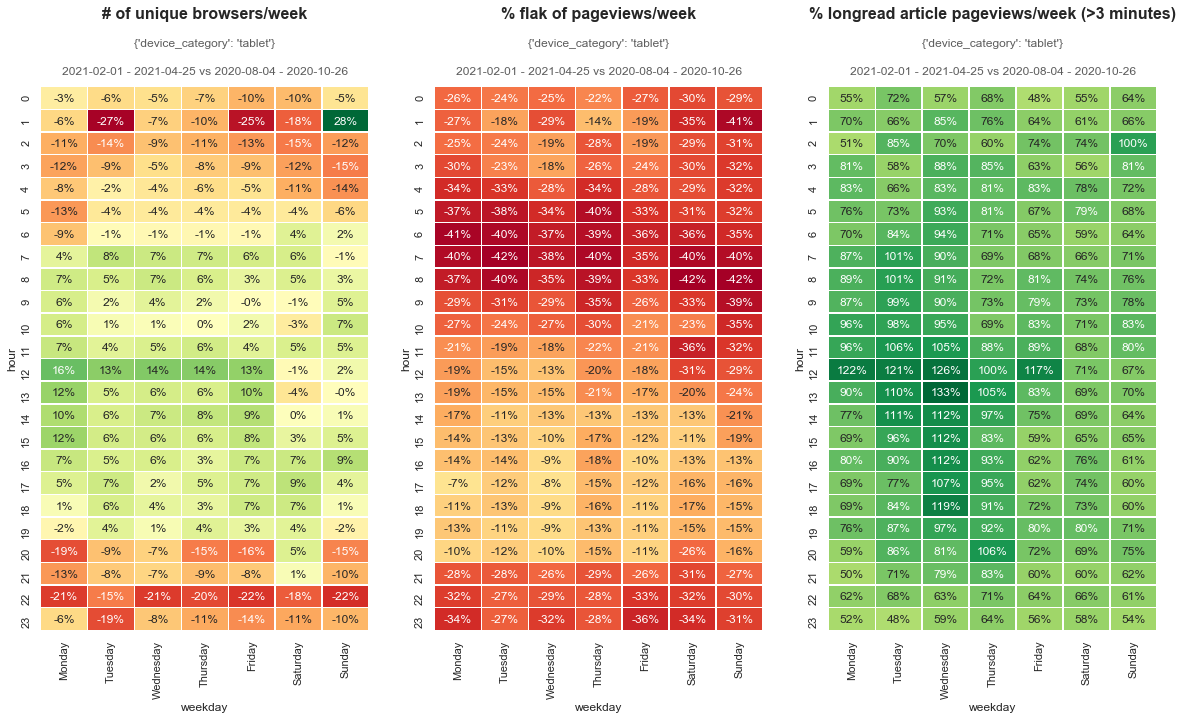

In [18]:
# Maximum three metrics!
metrics = {
    'n_browsers': '# of unique browsers/week',
    'share_flak_pageviews': '% flak of pageviews/week',
    'share_real_longreads': '% longread article pageviews/week (>3 minutes)'
}

# Select which sections to examine.
grouping_list = df_reading[f'{GROUPING}'].unique()

for val in grouping_list:
    
    # Select filtering parameters
    params = {
        f'{GROUPING}': f'{val}',
        
        # YOU CAN INCLUDE OTHER "FAKE" PARAMETERS. IT WON'T FILTER ON THIS BUT WILL WRITE IT OUT IN THE GRAPH. 
        #'login_status': 'Logged Out'
        #'section': 'Kultur' 
    }

    # Visualise behavioural heatmaps
    heatmap(params=params, 
            data=df_reading, 
            metrics=metrics,
            dates=dates, 
            comp_data=df_reading_comp); # add comp_data=df_reading_comp 

    #plt.savefig(f'{FROM_DATE}_engagement_{TO_DATE}_{params}.png')
    #plt.savefig(f'{FROM_DATE}_engagementcomp_{TO_DATE}_{params}.png')

## 3.2 ARTICLE PUBLICATIONS

In [19]:
# Use this if you want to look at posting patterns in aggregate.
df_posting_all = df_posting.groupby(['weekday', 'hour']).aggregate({'n_publications':'sum'}).reset_index()
df_posting_all_comp = df_posting_comp.groupby(['weekday', 'hour']).aggregate({'n_publications':'sum'}).reset_index()

In [20]:
# Use to clean data if necessary. 
df_posting = (
    df_posting
    .query('section in ("Världen", "Sverige", "Ekonomi", "Kultur", "Sport", "STHLM", "Gbg", "Ledare", "DN Debatt", "Insidan")')
)

df_posting = (
    df_posting
    .query('section in ("Världen", "Sverige", "Ekonomi", "Kultur", "Sport", "STHLM", "Gbg", "Ledare", "DN Debatt", "Insidan")')
)

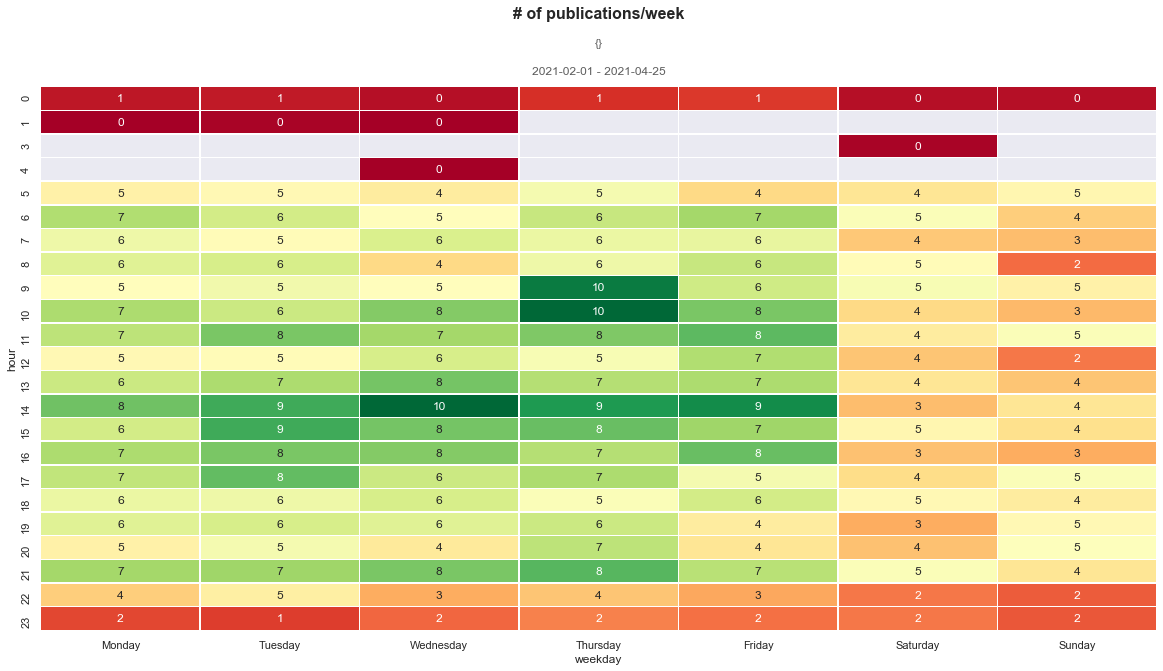

In [21]:
# Maximum three metrics!
metrics = {
    'n_publications': '# of publications/week',
}

# Select which sections to examine.
grouping_list = df_posting[f'section'].unique()

for val in grouping_list:
    
    # Select filtering parameters
    params = {
        #'section': f'{val}' # Select/deselect depending if you want to break down on sections or not.
    }

    # Visualise behavioural heatmaps
    heatmap(params=params, 
            data=df_posting_all, # Switch between "" or "_all" depending if you want to break down on sections or not.
            metrics=metrics,
            dates=dates); # add comp_data=df_posting_comp 

    #plt.savefig(f'{FROM_DATE}_posting_{TO_DATE}_{params}.png')
    #plt.savefig(f'{FROM_DATE}_postingcomp_{TO_DATE}_{params}.png')
    
    try: # If we insert no grouping parameter, don't loop unnecessarily. 
        params['section']
    except:
        break

### Query Totals (Skip if only interested in grouping)

In [22]:
df = pd.read_gbq(reading_query_text(from_date=FROM_DATE, to_date=TO_DATE, grouping='Total'), project_id=PROJECT)
df_comp = pd.read_gbq(reading_query_text(from_date=FROM_DATE_COMP, to_date=TO_DATE_COMP, grouping='Total'), project_id=PROJECT)

Downloading: 100%|██████████| 2015/2015 [00:00<00:00, 3155.49rows/s]


In [23]:
df = remove_outliers(data=df, partition='Total')
df_comp = remove_outliers(data=df_comp, partition='Total')

# Eliminate dates from data - group on weekday and hour (+ extra grouping)
df = df.groupby(['weekday', 'hour', 'Total']).aggregate(kpis).reset_index()
df_comp = df_comp.groupby(['weekday', 'hour', 'Total']).aggregate(kpis).reset_index()

transform_weekday(data=df)
transform_weekday(data=df_comp)

99.0% of original data remains.
100.0% of original data remains.


In [24]:
df = add_metrics(df)
df_comp = add_metrics(df_comp)

In [25]:
def timeline_by_weekday(segment, metric):
    
    # Merge total data with grouped data.
    df_merged = pd.merge(df_reading, df, how='left', on=['weekday', 'hour'], suffixes=(f'_{GROUPING.upper()}','_TOTAL'))
    
    # Calculate share of 
    df_merged = (
        df_merged
        .assign(share_pageviews=lambda x: x[f'n_pageviews_{GROUPING.upper()}'] / x['n_pageviews_TOTAL'])
        .assign(share_flak_pageviews=lambda x: x[f'n_article_pageviews_{GROUPING.upper()}'] / x['n_article_pageviews_TOTAL'])
        .assign(share_article_pageviews=lambda x: x[f'n_flak_pageviews_{GROUPING.upper()}'] / x['n_flak_pageviews_TOTAL'])
        .assign(share_longreads=lambda x: x[f'n_longreads_{GROUPING.upper()}'] / x['n_longreads_TOTAL'])
    )
    
    params = {f'{GROUPING}': segment}

    df_merged = filter_params(data=df_merged, params=params)

    df_merged = standard_pivot(data=df_merged, value=metric)

    
    # Visualise ... 
    sns.set(rc={'figure.figsize':(20,10)})
    sns.set_style("ticks")
    sns.set_context("poster")

    f, ax = plt.subplots()
    
    sns.lineplot(data=df_merged);
    
    plt.ylabel(f'{metric.upper().replace("_", " OF ")}')
    plt.title(f'{segment.upper()} {metric.upper().replace("_", " OF ")}')

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))


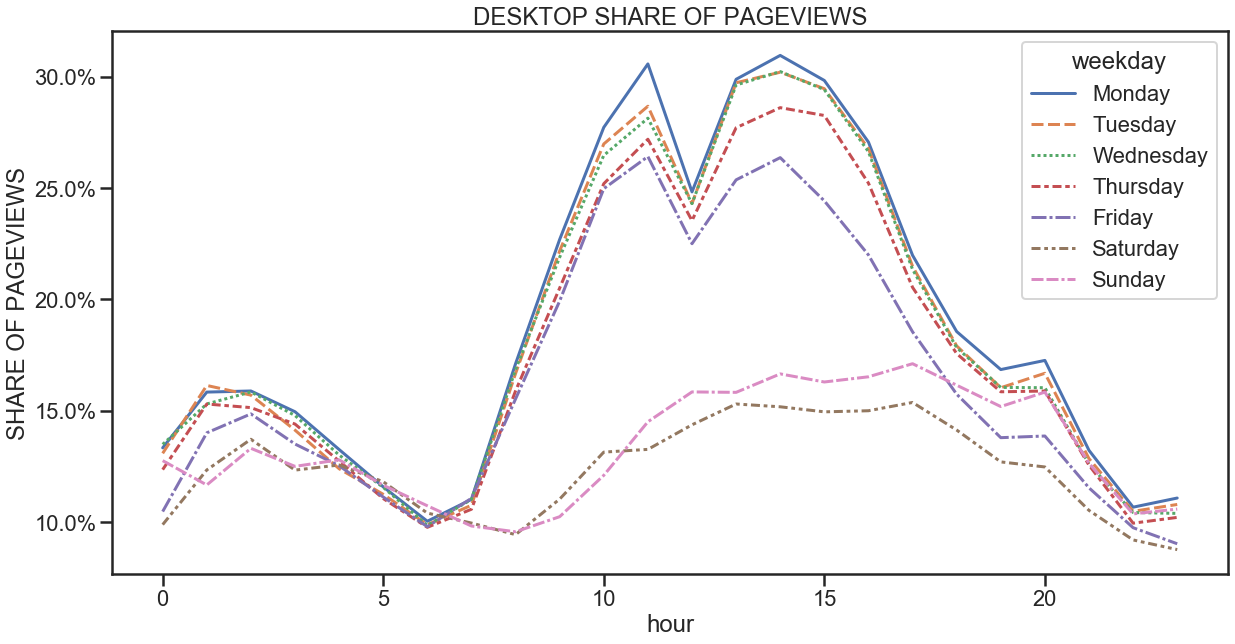

In [26]:
# Possible segments: based on which GROUPING is currently activated.
# Possible metrics: share_pageviews, share_article_pageviews, share_flak_pageviews, share_longreads.
timeline_by_weekday(segment='desktop', metric='share_pageviews')

In [27]:
def timelines_by_segment_comparison(segment1, segment2, metric):
    
    # Do this to be able to use the Total as a segment as well.
    df_merged = df.rename(columns={'Total': f'{GROUPING}'})
    
    # Add the totals to the segmented dataset. 
    df_merged = pd.concat([df_reading, df_merged])
    
    # Extract two segments to compare.
    df_merged = (
        df_merged
        .query(f'{GROUPING}.str.contains("{segment1}|{segment2}")', engine='python')
    )
    
    # Make the weekdays into categorial variables.
    df_merged['weekday'] = pd.Categorical(df_merged['weekday'], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
    
    # Visualise!
    sns.set(rc={'figure.figsize':(20,10)})
    sns.set_style("ticks")
    sns.set_context("talk")
    
    g = sns.relplot(
        data=df_merged, x="hour", y=metric,
        col="weekday", hue=f"{GROUPING}", kind="line", col_wrap=2
    )
    
    for ax in g.axes.flatten():
        ax.tick_params(direction='in', labelbottom=True)    
    

/Users/abtin.salahshor.bn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


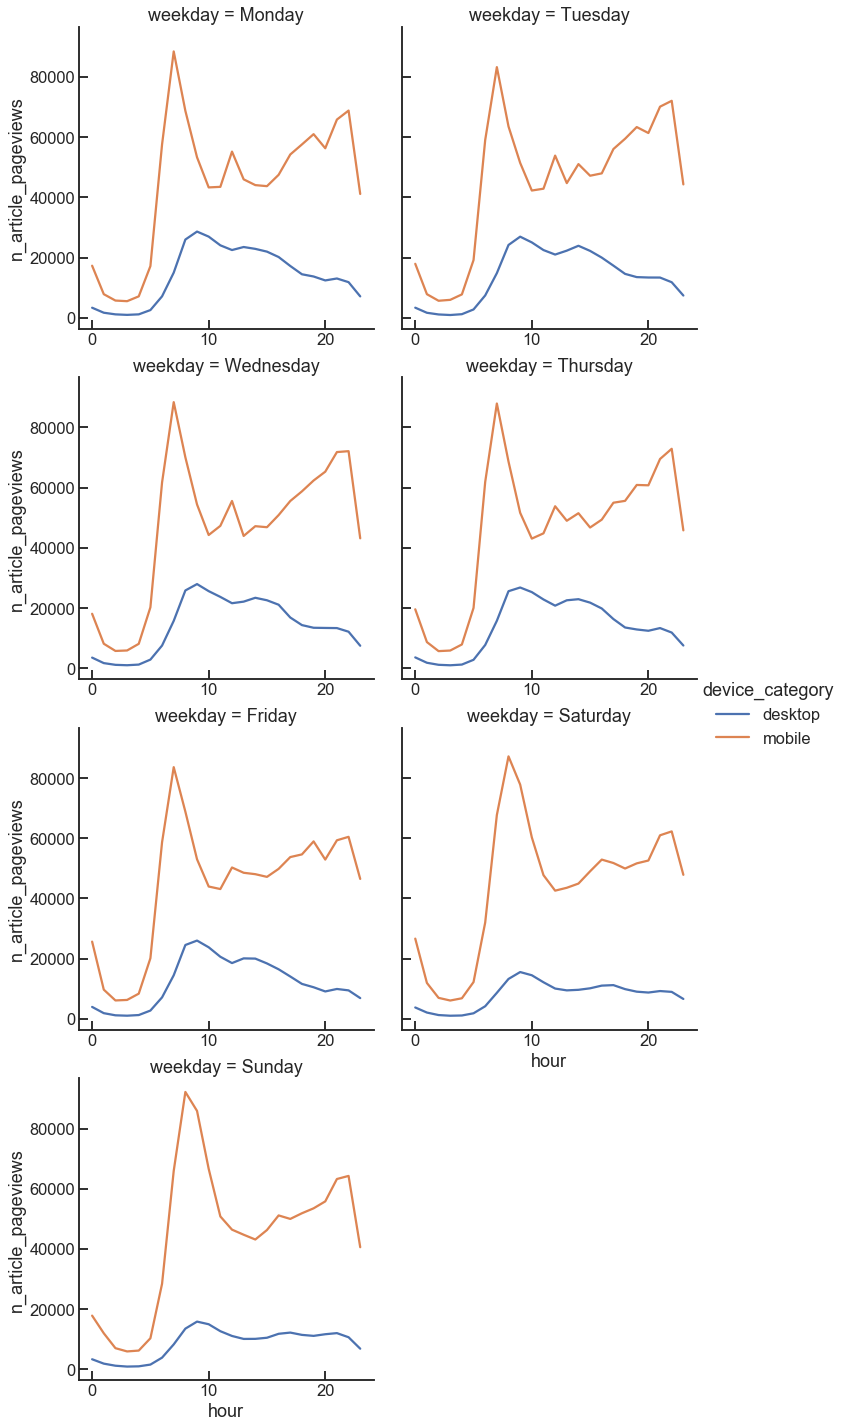

In [28]:
timelines_by_segment_comparison(segment1='desktop', segment2='mobile', metric='n_article_pageviews')